In [1]:
import os
import math
from shutil import copyfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.backends.cudnn as cudnn
from torchvision.transforms import InterpolationMode
from torchvision import models

import numpy as np
import random

from utils.common import setup_seed 
# from utils.loader import environments, init_dataset_train
from torch import nn
from tqdm import tqdm
from torch.utils.data import Subset, DataLoader

from torch.nn import functional as F
from MLPN.loader import init_dataset_train
from utils.loader import  init_dataset_test, environments, tensor2label, label2tensor, init_dataset_test
from utils.metrics import metrics
from FFM.model import CSWinTransv2_threeIn
from FFM.utils import extract_feature, get_id, extract_feature, SAM, SupConLoss, one_LPN_output

from tqdm.contrib import tzip

import tarfile
import zipfile

from LPN.image_folder_ import CustomData160k_drone, CustomData160k_sat
from utils.competition import get_result_rank10, get_SatId_160k


class DomainClassifier(nn.Module):
    def __init__(self, domin_num=10) -> None:
        super(DomainClassifier, self).__init__()
        
        # adatped from modern backbone, change last fc to adopt domain
        self.net = models.resnet18(pretrained=True)
        ftr_num = self.net.fc.in_features
        self.net.fc = nn.Linear(ftr_num, domin_num)

    def forward(self, x):
        return self.net(x)   

class Ours:
    def __init__(self, 
                 use_wandb=True,
                 wandb_key = '16c9a3f92163ef4df08841029e02fded0cd0cfed'
                 ) -> None:
        self.seed = 2024
        self.use_wandb = use_wandb # use wandb to monitor training instead of CLI
        self.wandb_key = wandb_key
        # init
        setup_seed(self.seed)
        self.model_dir = os.path.join(os.getcwd(), 'model', 'Ours')
        os.environ['TORCH_HOME']='./' 

        if not os.path.isdir(self.model_dir):
            os.makedirs(self.model_dir)    
        # 
        # self.domain_classifer = DomainClassifier() 

    

    def get(self, data160k_dir='D://dataset/university-160k-wx', save_file = 'answer.txt', pth=None, multiple_scale=[1], batchsize=128, DC_file='DomainClassifier_060.pth'):
        query_name = os.path.join(data160k_dir, 'query_drone_name.txt')
        data_transforms = transforms.Compose([
            transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        image_dataset = CustomData160k_drone( os.path.join(data160k_dir, 'query_drone160k_wx') ,data_transforms, query_name = query_name)
        dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=batchsize, shuffle=False, num_workers=16)

        ## load Domain Classifier model
        DC_file = os.path.join(self.model_dir, DC_file)
        domain_classifier = DomainClassifier()
        domain_classifier.load_state_dict(torch.load(DC_file)) 
        domain_classifier = domain_classifier.cuda()
        domain_classifier.train(False)

        ret = {}
        
        for data in tqdm(dataloader):
            img, label = data 
            img_ = img.cuda()
            logits = domain_classifier(img_)
            weather = tensor2label(logits)
            for i in range(len(label)):
                ret[label[i]] = weather[i]

        return ret 
    

c:\Users\lyq\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m = Ours()
x = m.get()


c:\Users\lyq\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\lyq\.conda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 296/296 [01:31<00:00,  3.22it/s]


In [3]:
import json 
with open("weather.json",'w') as f:
    json.dump(x, f)

fog_snow


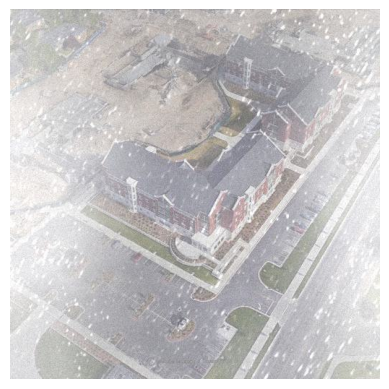

In [46]:
with open("weather.json",'r') as load_f:
    ww = json.load(load_f)

files = list(ww.keys())
img_name = np.random.choice(files)

import matplotlib.pyplot as plt
img = plt.imread(os.path.join('D://dataset/university-160k-wx/query_drone160k_wx', img_name+'.jpeg'))
plt.imshow(img)
plt.axis('off')
print(ww[img_name])


In [43]:
def find(style='fog_rain'):
    with open("weather.json",'r') as load_f:
        ww = json.load(load_f)
    ret = []
    for i in ww:
        if ww[i] == style:
            ret.append(i)
    return ret  

def change(name_list, source_dir='D://dataset/university-160k-wx/query_drone160k_wx', target_dir='D://dataset/university-160k-wxs/query_drone160k_wx'):
    for i in name_list:
        name = os.path.join(source_dir, i)

        #some process

        




In [42]:
x = find()
print(x)

['BiiPt9YNGa8We7I', 'AbKIzAxRwWSy2Kb', 'FbMMO8EKQ4QoIZf', 'pSekbJTkXSnWViS', '2L0UK7tVYgbOXCg', 'cQL9vUXQ5NGK6rO', 'w13rqBuBbpFoJG2', 'wgSDxjA1TTNR1vl', 'hfo0vYr1S4dz2Yf', 'esEGPu6pHzk6Kj1', 'R2Y02KamRH5iWvA', 'GoWbAiqV7op1GcL', 'QUNX7Lp58qfiau3', 'BBIZFOv6jO5lNAi', '0mLhb8u5xzF25vH', 'XPLNMBKclyHUAyI', 'wnJe4F8kC4my0py', 'MIJ8JBybBGf3EvE', 'MUgQB62Ia0Et9Mv', 'RK3C2NGxi8tZP2T', 'XC4d8ruklNKNDer', 't7JyS7fzCF1wTTg', 'z4KXA2fzUAL5sxQ', 'BaiWdpZ6Z4v0DYX', 'auu2JDiEjZcx6LK', 'q2q8QM9wRYyQYhV', 'BfIHVF1AVYeTiaS', 'xv2TlnmWVtq8BOX', '0LyrlMAtHGKPRTX', 'HxCZl9MzuQp4ZsI', 'qs3lxHh7lbUflNJ', '7jFPzRnnbLQdvTQ', 'z3MhQ45CpAfzZmF', 'AySa8k82c9d42cK', 'WUdObVCjFFBN7h1', 'vAsQFFCwEuMjiHi', '0mAQO5cvR13oHCt', 'ZwYbhPoMQHrJ5h7', 'ti0zvWNrPd250em', 'fb2Nw2NM3k5wP4t', 'h5mV4T25lwtz12U', '923tS4yQ7pdPLE5', 'H7iaerSMLiVkhQY', 'GSaOWLnqWoUTtUz', 'f0vVwk0RgkUtckU', 'y7E4kH6614KIkKK', 'Y7PMFTKDzDGWTGu', 'C8WJEm9titOiEG3', 'hMpwzesiMD8I4CU', 'BZbxg6CYYbTZevb', '0fD19bqIah3m1n9', 'G2gW5klwhw0nVoE', 'kVVLxTXjQG